In [1]:
import matplotlib.pylab as plt
import numpy as np

from pandas import read_excel , DataFrame , ExcelWriter 
from scipy.stats import linregress

In [9]:
def writeEnd(path): #write 'end' at the end of the xlsx file, so the program knows where to stop
    df = read_excel(path)
    word = DataFrame({'a':['end']})
    writer = ExcelWriter(path,engine = 'openpyxl')
    df.to_excel(writer, index=False)
    word.to_excel(writer, startrow=len(df)+2, index=False)
    writer.save()

def divideData(path):   #divide data into different sets, according to indices in the first column.
    writeEnd(path)
    df = read_excel(path)
    data = df.as_matrix()
    experims = []
    e = 0
    while (e != np.size(data,0)):
        if data[e,0] == 1:   #start when data has index one
            length = 0
            begin = e
            i = e   #change variable for next while loop
            while type(data[i,0]) == int:  #count until first term is no longer an int
                i += 1
                length += 1
            newMat = data[begin:(length+begin),:]   #take rows with first index integer
            experims.append(newMat)
        e += 1
        
    return experims

def maximR2(xs,ys,axes, minim_dots = 5):  #checks for the best value of R^2 
    maxR2 = 0 
    bestind = [] #indices of points for maximum R2
    best_params = []  #best parameters found [slope,intercept]
    num_dots = minim_dots
    start = 0
    iters = 0
    """starts by checking the first num_dots dots, then moves to the next and so on.
    when it's done with the data set, increments num_dots by one.
    keep doing this until num_dots == len of the list"""
    while num_dots < (len(ys)):
        iters+=1
        ends = start + num_dots
        x = [i for i in xs[start:ends]]
        y = [i for i in ys[start:ends]]
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        R2 = r_value**2

        if R2 > maxR2:
            maxR2 = R2
            bestind = [start,ends]
            best_params = [slope,intercept]        
        if ends == len(ys):
            start = 0
            num_dots += 1
        start +=1

    #plot fit
    p = np.poly1d(best_params)
    x = [xs[bestind[0]],xs[bestind[1]-1]]
    y = [p(i) for i in x]
    axes.plot(x,y,'k-',zorder=10)
     
    return maxR2 , best_params

def Angulo(intercept):
    global perim,TSagua
    costheta=intercept*1000/(perim*TSagua)
    if costheta > 1:
        theta = np.arccos(1)
    else:
        theta = np.arccos(costheta)
    
    return round(theta*180/np.pi,2)

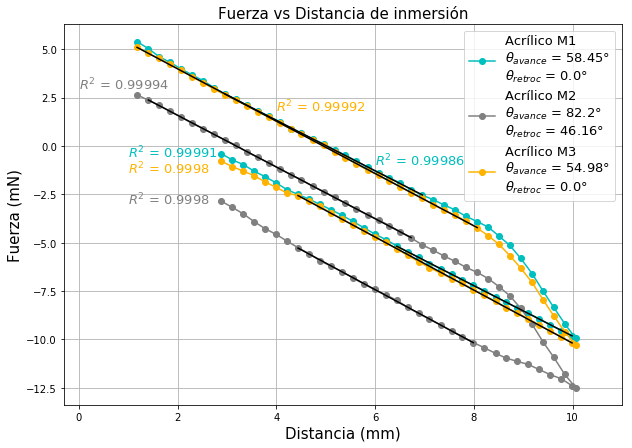

In [10]:
path = './ac_data.xlsx'
data = divideData(path)

for i in range(len(data)):
    data[i] = data[i][:,0:5]
    
perim = 2*(39+3.2)
TSagua = 72.8


fig = plt.figure(figsize = (10,7))
ax1 = fig.add_subplot(111)
fsize = 15
ax1.set_title('Fuerza vs Distancia de inmersión', fontsize = fsize)
ax1.set_xlabel('Distancia (mm)',fontsize = fsize)
ax1.set_ylabel('Fuerza (mN)' ,fontsize = fsize)
ax1.set_xlim((-0.3,11))

labels = {0:['Acrílico M1','c'],1:['Acrílico M2',(0.5,0.5,0.5)],2:['Acrílico M3',(1,0.7,0)]}
labelRi = {0:(1,-0.6),1:(1,-3),2:(1,-1.4)}
labelRf = {0:(6,-1),1:(0,2.9),2:(4,1.8)}


for i in range(len(data)):
    position = [i for i in data[i][:,2]]
    force = [i for i in data[i][:,3]]
    n = 13
    xsplot = position[n:] #get rid of the first n points
    ysplot = force[n:]
    
    #Linear regression: advancing 
    end = 46
    xs = position[:end]
    ys = force[:end]
    R2, params1= maximR2(xs,ys,ax1,minim_dots=8)
    ax1.text(labelRi[i][0],labelRi[i][1],'$R^2$ = ' +str(round(R2,5)), fontsize = 13,color = labels[i][1])
    
    #Linear regression: receding 
    init = 46
    xs = position[init:]
    ys = force[init:]
    R2, params2 = maximR2(xs,ys,ax1,minim_dots=8)
    ax1.text(labelRf[i][0],labelRf[i][1],'$R^2$ = ' +str(round(R2,5)), fontsize = 13,color = labels[i][1])
    
    ax1.plot(xsplot,ysplot, 
             marker = 'o',
             label = labels[i][0]+'\n'+r'$\theta_{avance}$ = '+str(Angulo(params1[1])) + '°'+
                     '\n'+r'$\theta_{retroc}$ = '+str(Angulo(params2[1])) + '°',
             color = labels[i][1])
    
plt.grid()
plt.legend(fontsize = 13)
plt.savefig('ac_1.png',dpi=300)
plt.show()